In [182]:
import numpy as np
import matplotlib.pyplot as plt
from SpringMassSystem import SpringMassSystem
import scipy.integrate as integrate
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
# initialize the SpringMass model

ndim = 2          # choose between 1D (ndim=1) or 2D (ndim=2) system
N_m = 11          # number of nodes
L0 = 5 / N_m      # springs' rest length
k0 = 10           # spring stiffness (f = k*dx)
m0 = 0.1 / N_m    # node mass

model = SpringMassSystem(ndim, N_m, L0, k0, m0)
# model.initialize_as_caternary()

In [191]:
# solve the model ODE

dt = 0.02         # set evaluation timestep (this sets the solver's max stepsize)
t_eval = np.arange(0,50,dt)

sol = integrate.solve_ivp(
    fun=model.compute_augmented_xdot, 
    t_span=[t_eval[0], t_eval[-1]], 
    t_eval=t_eval,
    y0=model.get_initial_X_aug(), 
    method='RK45',)

# solution data - times, positions, velocities
t = sol.t
X_t = np.reshape(sol.y[:N_m * ndim,:], (N_m,-1,len(t)))
Xdot_t = np.reshape(sol.y[N_m * ndim:,:], (N_m,-1,len(t)))


X_t = np.concatenate((
    np.kron(np.ones((1,len(t))), model.xL.T)[np.newaxis,:,:],
    X_t,
    np.kron(np.ones((1,len(t))), model.xR.T)[np.newaxis,:,:]
))

<IPython.core.display.Javascript object>


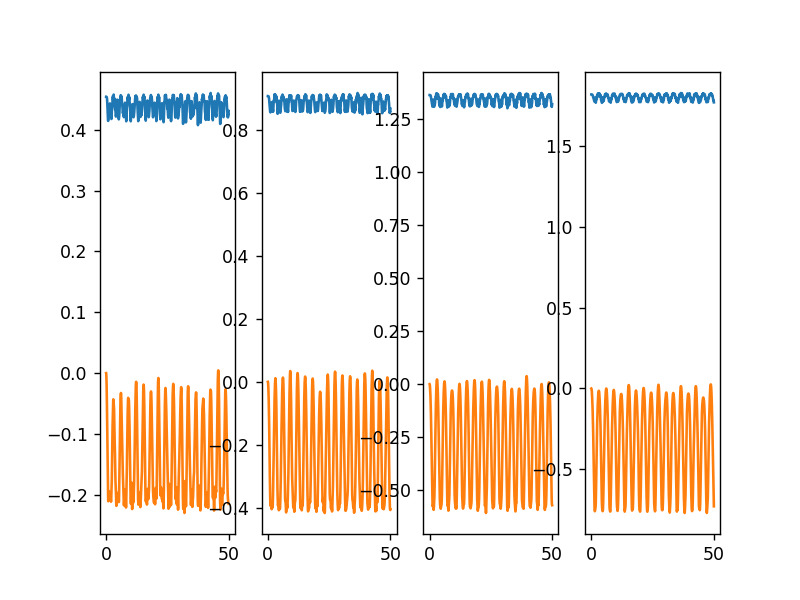

In [192]:
num_plots = min(N_m, 4)
fig, axs = plt.subplots(1, num_plots)
for i in range(num_plots):
    axs[i].plot(t, X_t[i+1,:,:].T)

In [193]:
import matplotlib.animation as animation
from collections import deque

history_len = len(t)  # how many trajectory points to display

L = 3
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False, xlim=(-L + L0*(N_m+1)/2, L + L0*(N_m+1)/2), ylim=(-L, L))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
trace, = ax.plot([], [], '.-', lw=1, ms=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
history_x, history_y = deque(maxlen=history_len), deque(maxlen=history_len)


def animate(i):
    thisx = X_t[:, 0, i]
    if ndim == 1:
        thisy = np.zeros_like(thisx)
    else:
        thisy = X_t[:, 1, i]

    if i == 0:
        history_x.clear()
        history_y.clear()

    history_x.appendleft(thisx[1 + (N_m // 2)])
    history_y.appendleft(thisy[1 + (N_m // 2)])

    line.set_data(thisx, thisy)
    trace.set_data(history_x, history_y)
    time_text.set_text(time_template % (i*dt))
    return line, trace, time_text


ani = animation.FuncAnimation(
    fig, animate, len(t), interval=dt*1000, blit=True)
plt.show()

<IPython.core.display.Javascript object>

In [177]:
def accel(t, x):
    return -0.2 * x

sol = integrate.solve_ivp(
    fun= lambda t, X: np.array([X[1], accel(t, X[0])]), 
    t_span=[0,10], 
    t_eval=np.linspace(0,10,101),
    y0=np.array([0,1]), 
    method='RK45',)

[0. 1.]
[-2.17230933 -0.23688274]


<IPython.core.display.Javascript object>


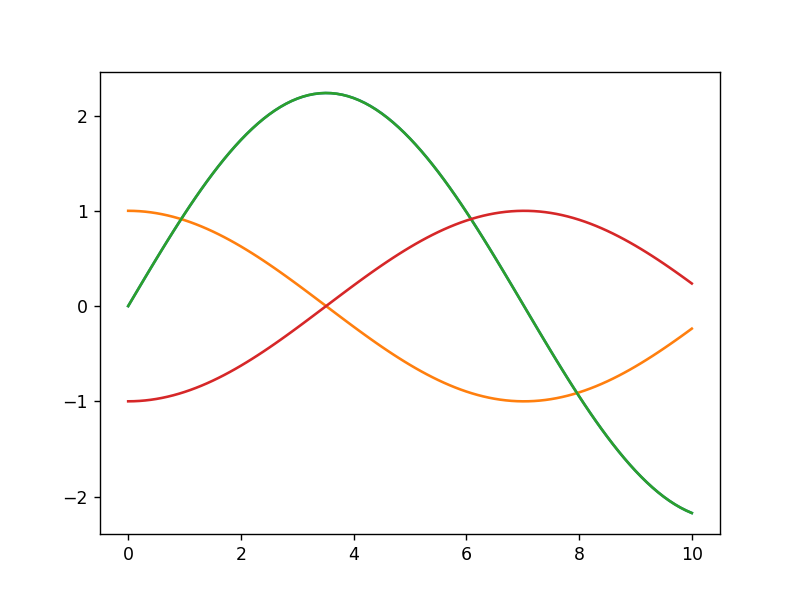

In [180]:
print(sol.y[:,0])
print(sol.y[:,-1])
plt.plot(sol.t, sol.y[0,:])
plt.plot(sol.t, sol.y[1,:])
plt.show()

In [181]:
sol_bwd = integrate.solve_ivp(
    fun= lambda t, X: np.array([X[1], accel(t, X[0])]), 
    t_span=[0,10], 
    t_eval=np.linspace(0,10,101),
    y0=np.diag([1,-1]) @ sol.y[:,-1], 
    method='RK45',)

print(sol_bwd.y[:,0])
print(sol_bwd.y[:,-1])
plt.plot(sol_bwd.t[::-1], sol_bwd.y[0,:])
plt.plot(sol_bwd.t[::-1], sol_bwd.y[1,:])
plt.show()

[-2.17230933  0.23688274]
[ 8.94636238e-06 -9.99892712e-01]
